<h3>Coloane de interes din dataset</h3>

<p>ex file row:</p> 
<table>
<tr>
    <td><strong>2019-01-31 23:59:59.713000</strong></td>
    <td><strong>000.021.202.100</strong></td>
    <td>CO2</td>
    <td><strong>1419</strong></td>
    <td>2000</td>
    <td>1000</td>
    <td>DI</td>
    <td>0</td>
    <td>DI</td>
</tr>
</table>


<p>row[0] (timedate):   2019-01-31 23:59:59.713000</p>
<p>row[1] (device ip):  000.021.202.100</p>
<p>row[3] (co2 value):  1419</p>

In [2]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

time_format = r'%Y-%m-%d %H:%M:%S.%f'
file_ids = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
example_device = '000.021.194.023'


<h3>Date lipsă</h3>

<p>Dupa intersectia device-urilor din coloana [1] au rezultat 76 de comune in toate fisierele (salvat in common_ids.txt).Restul avand valori lipsa in cel putin unul dintre fisiere. Pentru a rezolva problema device-urilor cu missing values o sa se faca drop la acestea in toate fisierele.</p>

In [106]:
with open('common_ids.txt', 'rb') as fin:
    devices = fin.read().decode('utf-16').replace('\'', '').replace(' ', '')
devices = devices.split(',')
for i in file_ids:
    df1 = pd.read_csv(f'data/CO2_{i}_2019.csv', header=None)
    df2 = pd.read_csv(f'data/RADON_{i}_2019.csv', header=None)
    
    df1 = df1[df1[1].isin(devices)]
    df2 = df2[df2[1].isin(devices)]

    df1.to_csv(f'processed_data/CO2_{i}_2019.csv', index=False, header=None)
    df2.to_csv(f'processed_data/RADON_{i}_2019.csv', index=False, header=None)



<h3>Descrierea Datelor</h3>

In [112]:
df = pd.read_csv(f'processed_data/CO2_01_2019.csv', header=None)
print('CO2: ')
print(df[3].describe())
print('\nRADON: ')
df = pd.read_csv(f'processed_data/RADON_01_2019.csv', header=None)
print(df[3].describe())

CO2: 
count    1.318248e+06
mean     1.211209e+03
std      8.145870e+02
min      1.000000e+02
25%      6.520000e+02
50%      9.600000e+02
75%      1.453000e+03
max      4.092000e+03
Name: 3, dtype: float64

RADON: 
count    1.318898e+06
mean     5.095236e+02
std      3.744535e+02
min      0.000000e+00
25%      2.570000e+02
50%      4.030000e+02
75%      6.670000e+02
max      4.479000e+03
Name: 3, dtype: float64


<h3>Handling outliers</h3>
<ul>
    <li>A fost folosit un Z-score pentru valorile de C02, respectiv RADON.</li>
    <li>Se poate observa ca s-a schimbat shape-ul la dataframe deci set-ul de date contine outliers.</li>
</ul>
<p>CO2&emsp;: &emsp;22622436 -> 22040828</p>
<p>RN &emsp;: &emsp;22584391 -> 22421577</p>

In [1]:
dfs = []
for i in file_ids:
    df = pd.read_csv(f'Data/CO2_{i}_2019.csv', header=None)
    dfs.append(df[3])
df_co2 = pd.concat(dfs, ignore_index=True)
z = np.abs(stats.zscore(df_co2))
print(z)
print(f'CO2 df shape before outlier filter: {df_co2.shape}')
df_outliers = df_co2[z<3]
print(f'CO2 df shape after outlier filter: {df_outliers.shape}')

NameError: name 'file_ids' is not defined

In [50]:
dfs = []
for i in file_ids:
    df = pd.read_csv(f'Data/RADON_{i}_2019.csv', header=None)
    dfs.append(df[3])
df_radon = pd.concat(dfs, ignore_index=True, names=[0])
z = np.abs(stats.zscore(df_radon))
print(z)
print(f'RADON df shape before outlier filter: {df_radon.shape}')
df_outliers = df_radon[z<3]
print(f'RADON df shape after outlier filter: {df_outliers.shape}')


0            0.357717
1            0.744759
2            0.316733
3            1.132060
4            0.148698
              ...    
22584386    21.970503
22584387     0.855417
22584388     0.834925
22584389     1.511165
22584390     0.378209
Name: 3, Length: 22584391, dtype: float64
RADON df shape before outlier filter: (22584391,)
RADON df shape after outlier filter: (22421577,)


<h3>Preprocesarea setului de date</h3>
<p>Standardizare: <strong>StandardScaler</strong></p>

In [63]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
standardized_co2 = scaler.fit_transform(pd.DataFrame(df_co2))
standardized_radon = scaler.fit_transform(pd.DataFrame(df_radon))
print('Standardized CO2 values: ')
print(standardized_co2)
print('\nStandardized RADON values: ')
print(standardized_radon)

Standardized CO2 values: 
[[ 1.16496839]
 [ 0.64128286]
 [-0.59390213]
 ...
 [-0.42253907]
 [ 2.78126484]
 [-0.68712364]]

Standardized RADON values: 
[[-0.35771722]
 [ 0.74475915]
 [-0.31673297]
 ...
 [ 0.83492451]
 [ 1.51116466]
 [-0.37820935]]


<h3>Discretization</h3>

In [72]:
from sklearn.preprocessing import KBinsDiscretizer
disc = KBinsDiscretizer(n_bins=6, encode='onehot-dense', strategy='uniform', subsample=None)
discretized_co2 = disc.fit_transform(standardized_co2)
print(discretized_co2)
discretized_radon = disc.fit_transform(standardized_radon)
print(standardized_radon)

[[0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0.]]
[[-0.35771722]
 [ 0.74475915]
 [-0.31673297]
 ...
 [ 0.83492451]
 [ 1.51116466]
 [-0.37820935]]


In [46]:
co2 = ([], []) # datetime, co2_value
for i in file_ids:
    df = pd.read_csv(f'Data/CO2_{i}_2019.csv', header=None)
    df = df[df[1] == example_device]
    df[0] = pd.to_datetime(df[0], format=time_format)
    co2[0].append(df[0].to_list())
    co2[1].append(df[3].to_list())


<h3>Encoding column[0] in datetime + vector plotting valorile originale</h3>

In [54]:
radon = ([], []) # datetime, co2_value
for i in file_ids:
    df = pd.read_csv(f'Data/RADON_{i}_2019.csv', header=None)
    df = df[df[1] == example_device]
    df[0] = pd.to_datetime(df[0], format=time_format)
    radon[0].append(df[0].to_list())
    radon[1].append(df[3].to_list())


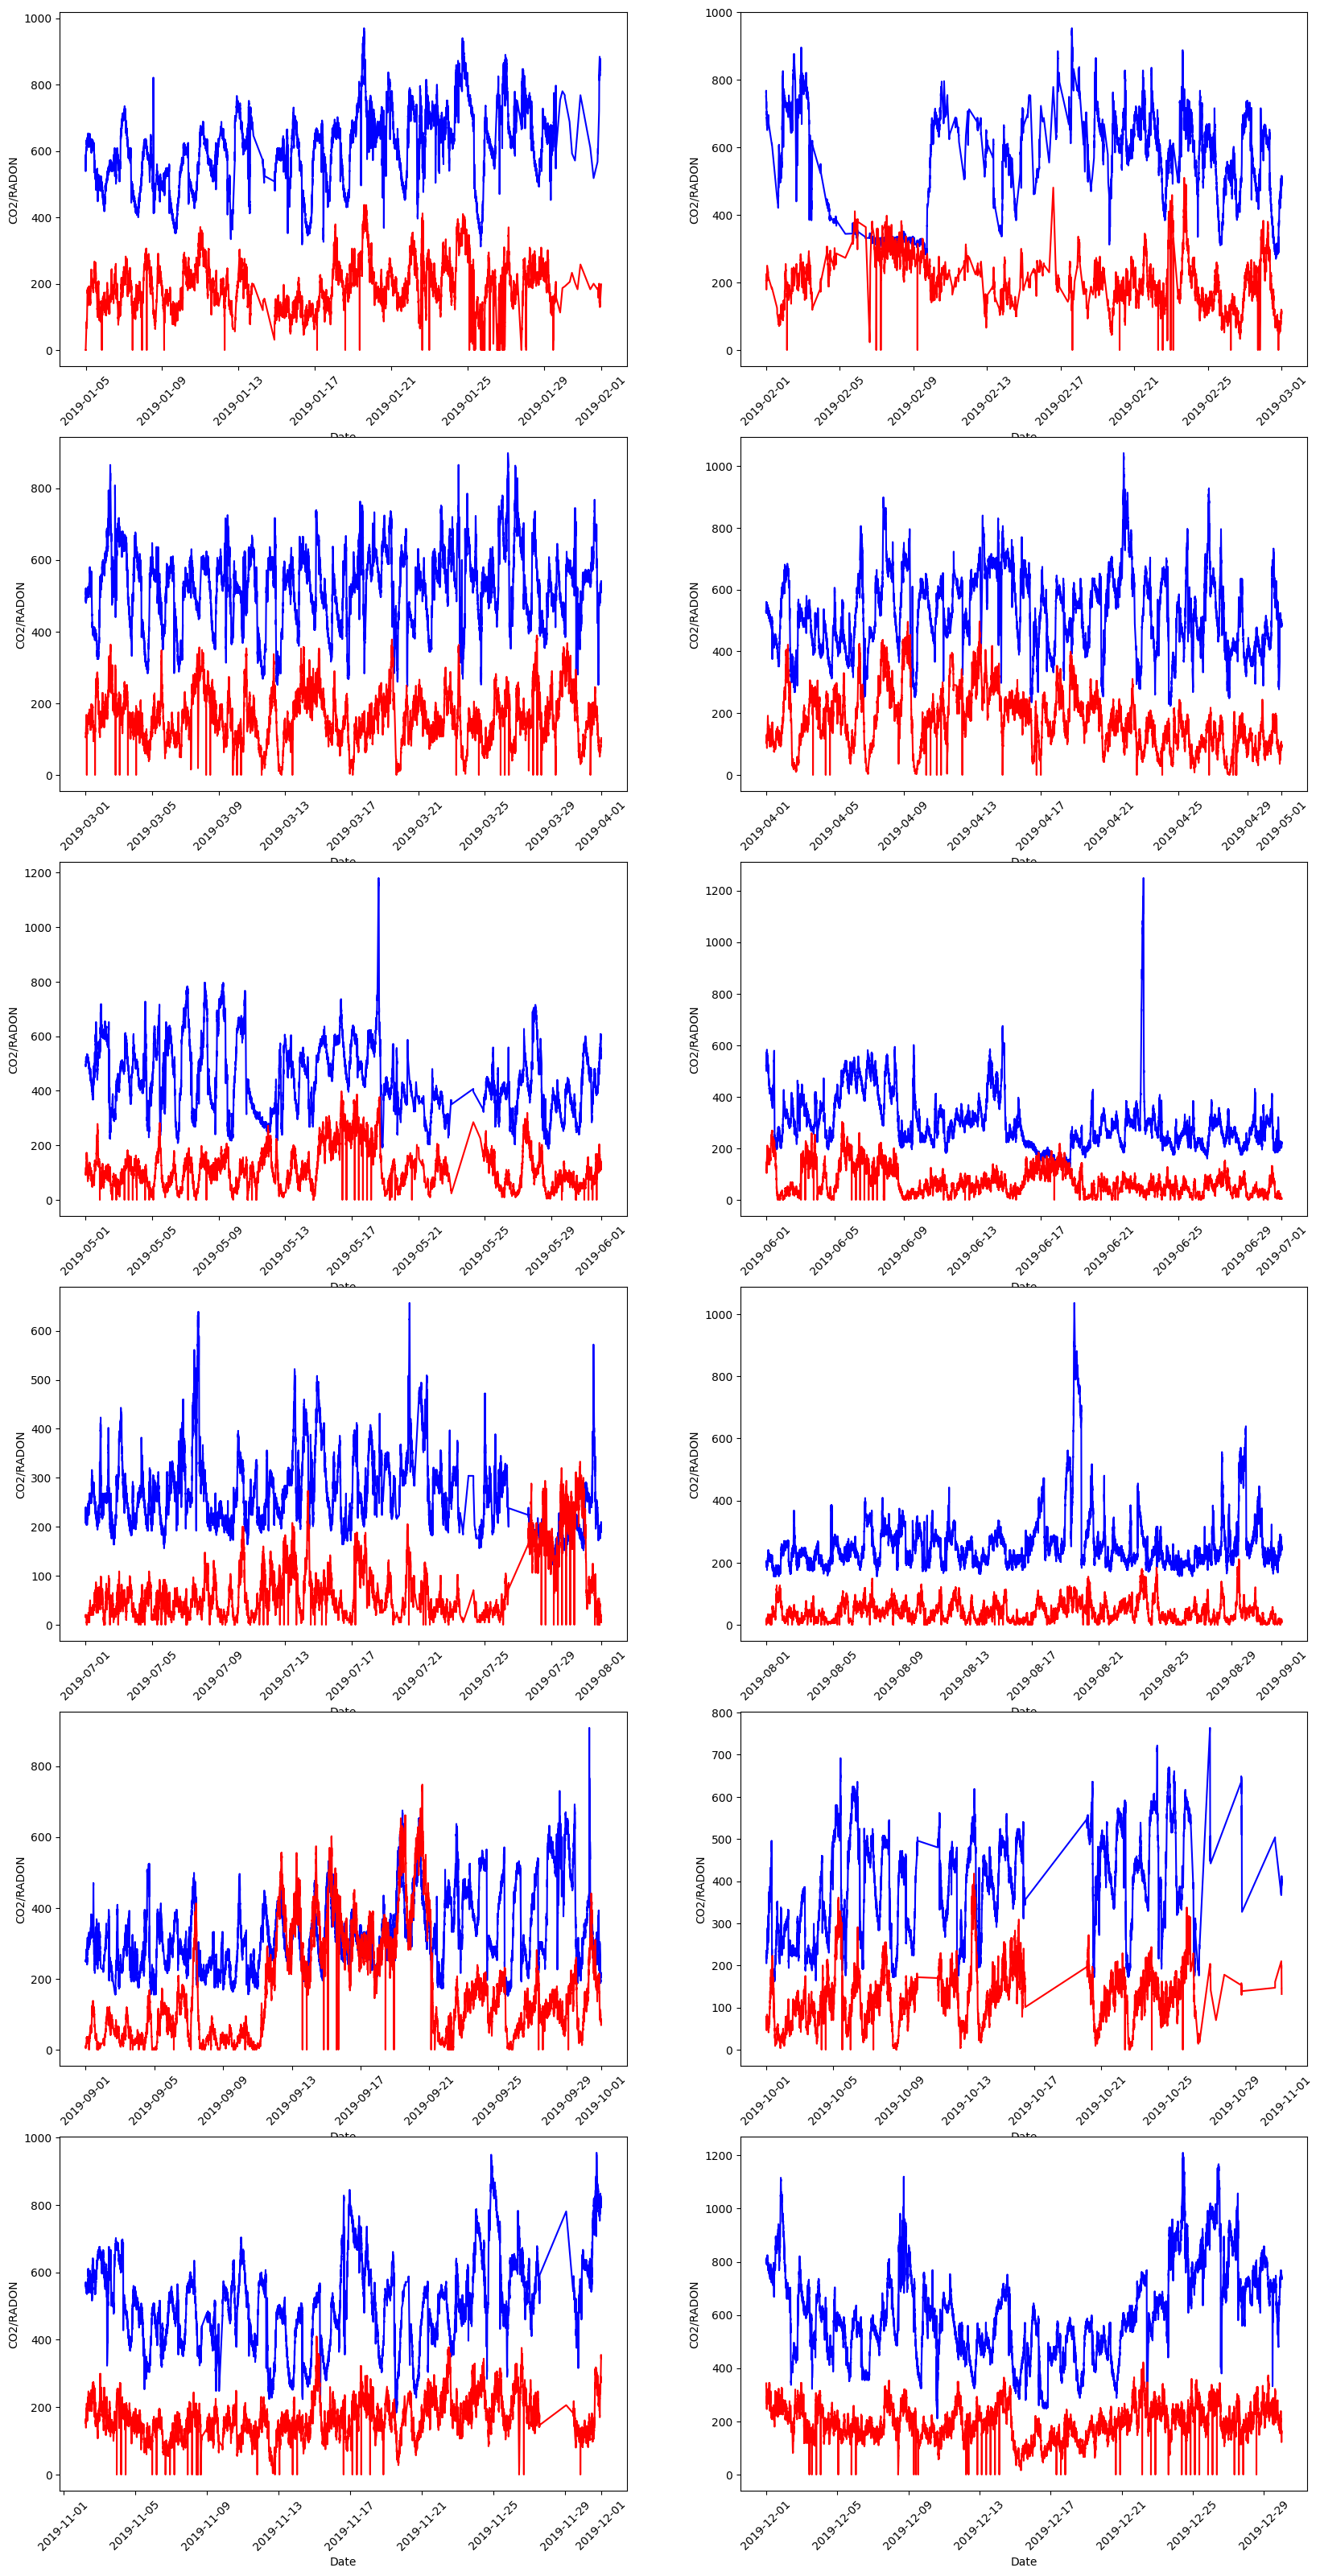

In [63]:

fig, axs = plt.subplots(6, 2, figsize=(20, 40))
axs = axs.flatten()
for i, ax in enumerate(axs):
    ax.plot(co2[0][i], co2[1][i], color='blue', label='co2')
    ax.plot(radon[0][i], radon[1][i], color='red', label='radon')
    ax.set_xlabel('Date')
    ax.set_ylabel('CO2/RADON')
    ax.tick_params(axis='x', rotation=45)

plt.show()